### Dataset

In [1]:
#! ..\wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-09-17 23:10:55--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: 'housing.csv.3'

     0K .......... .......... .......... .......... ..........  3% 1.02M 1s
    50K .......... .......... .......... .......... ..........  7% 1.93M 1s
   100K .......... .......... .......... .......... .......... 10% 1.66M 1s
   150K .......... .......... .......... .......... .......... 14% 3.64M 1s
   200K .......... .......... .......... .......... .......... 17% 1.58M 1s
   250K .......... .......... .......... .......... .......... 21% 2.21M 1s
   300K .......... .......... .......... .......... .......... 25% 2.88M 1s
   350K ......

### EDA

In [2]:
import pandas as pd
housing_df = pd.read_csv('housing.csv')

<Axes: ylabel='Density'>

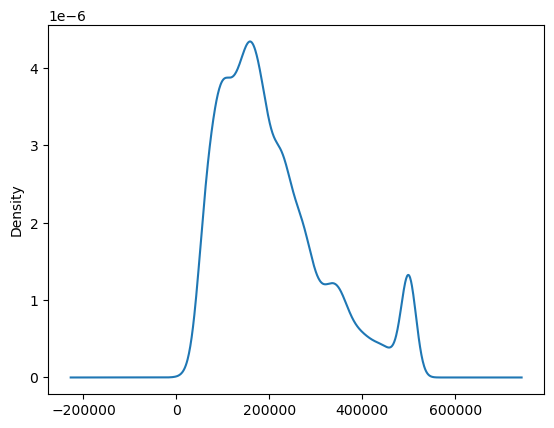

In [3]:
housing_df.median_house_value.plot.kde()

From the above kde plot we can infer that the distribution is not fat tailed but long tailed

### Preparing the dataset

In [4]:
housing_df_select = housing_df[(housing_df.ocean_proximity == '<1H OCEAN') | (housing_df.ocean_proximity == 'INLAND')]

In [5]:
housing_df_select = housing_df_select[['latitude',
'longitude',
'housing_median_age',
'total_rooms',
'total_bedrooms',
'population',
'households',
'median_income',
'median_house_value']]

### Question 1
`There's one feature with missing values. What is it?`

In [6]:
housing_df_select.isna().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

total_bedrooms feature has missing values

### Question 2
`What's the median (50% percentile) for variable 'population'?`

In [7]:
housing_df_select.population.quantile(0.5)

1195.0

In [8]:
housing_df_select.population.median()

1195.0

The median value is 1195

### Prepare and split the dataset

In [9]:
from sklearn.model_selection import train_test_split
housing_df_select_shuffled = housing_df_select.sample(frac = 1,random_state=42)
X = housing_df_select_shuffled.iloc[:,:-1]
y = housing_df_select_shuffled.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

In [10]:
import numpy as np
y_train = y_train.apply(lambda x: np.log1p(x))
y_val = y_val.apply(lambda x: np.log1p(x))
y_test = y_test.apply(lambda x: np.log1p(x))

In [11]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [12]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [13]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

### Question 3

Fill missing values with 0

In [14]:
X_null_train = X_train.copy()
X_null_val = X_val.copy()

In [15]:
X_train.isna().sum()

latitude               0
longitude              0
housing_median_age     0
total_rooms            0
total_bedrooms        98
population             0
households             0
median_income          0
dtype: int64

In [16]:
X_null_train.total_bedrooms.fillna(0,inplace=True)

In [17]:
X_null_val.total_bedrooms.fillna(0,inplace=True)

In [18]:
w_0_null, w_null = train_linear_regression(X_null_train.values, y_train.to_numpy())

In [19]:
y_null_pred_val = w_0_null + X_null_val.values.dot(w_null)

In [20]:
np.round(rmse(y_val.to_numpy(), y_null_pred_val),2)

0.34

Fill missing values with mean

In [21]:
col_mean = X_train.total_bedrooms.mean()
X_mean_train = X_train.copy()
X_mean_val = X_val.copy()
X_mean_train.total_bedrooms.fillna(col_mean,inplace=True)
X_mean_val.total_bedrooms.fillna(col_mean,inplace=True)

In [22]:
w_0_mean, w_mean = train_linear_regression(X_mean_train.values, y_train.to_numpy())

In [23]:
y_mean_pred_val = w_0_mean + X_mean_val.values.dot(w_mean)

In [24]:
np.round(rmse(y_val.to_numpy(), y_mean_pred_val),2)

0.34

Both the missing value imputations are equally good

### Question 4

In [25]:
rmse_list=[]
r_list = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
for r in r_list:
    w_0, w = train_linear_regression_reg(X_null_train.values, y_train.to_numpy(), r=r)
    y_null_reg_val = w_0 + X_null_val.values.dot(w)
    rmse_val = np.round(rmse(y_val.to_numpy(), y_null_reg_val),2)
    rmse_list.append(rmse_val)

In [26]:
rmse_list

[0.34, 0.34, 0.34, 0.34, 0.34, 0.34, 0.35, 0.35, 0.35]

Thus minimum r value is 0

### Question 5

In [27]:
rmse_list=[]
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
for seed in seeds:
    housing_df_select_shuffled = housing_df_select.sample(frac = 1,random_state=seed)
    X = housing_df_select_shuffled.iloc[:,:-1]
    y = housing_df_select_shuffled.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)
    y_train = y_train.apply(lambda x: np.log1p(x))
    y_val = y_val.apply(lambda x: np.log1p(x))
    y_test = y_test.apply(lambda x: np.log1p(x))
    X_null_train = X_train.copy()
    X_null_val = X_val.copy()
    X_null_train.total_bedrooms.fillna(0,inplace=True)
    X_null_val.total_bedrooms.fillna(0,inplace=True)
    w_0_null, w_null = train_linear_regression(X_null_train.values, y_train.to_numpy())
    y_null_pred_val = w_0_null + X_null_val.values.dot(w_null)
    rmse_list.append(np.round(rmse(y_val.to_numpy(), y_null_pred_val),2))

In [28]:
np.round(np.std(rmse_list),3)

0.007

### Question 6

In [29]:
housing_df_select_shuffled = housing_df_select.sample(frac = 1,random_state=9)
X = housing_df_select_shuffled.iloc[:,:-1]
y = housing_df_select_shuffled.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
y_train = y_train.apply(lambda x: np.log1p(x))
y_test = y_test.apply(lambda x: np.log1p(x))
X_null_train = X_train.copy()
X_null_test = X_test.copy()
X_null_train.total_bedrooms.fillna(0,inplace=True)
X_null_test.total_bedrooms.fillna(0,inplace=True)
w_0, w = train_linear_regression_reg(X_null_train.values, y_train.to_numpy(), r=0.001)
y_null_reg_test = w_0 + X_null_test.values.dot(w)
rmse_val = np.round(rmse(y_test.to_numpy(), y_null_reg_test),2)
rmse_val

0.33